# 데이터 처리하기

In [4]:
!unzip /content/256x256-20250510T101702Z-1-001.zip

Archive:  /content/256x256-20250510T101702Z-1-001.zip
   creating: 256x256/.ipynb_checkpoints/
  inflating: 256x256/img_grey_202501.png  
  inflating: 256x256/img_grey_202404.png  
  inflating: 256x256/img_grey_202402.png  
  inflating: 256x256/img_grey_202312.png  
  inflating: 256x256/img_grey_202311.png  
  inflating: 256x256/img_grey_202301.png  
  inflating: 256x256/img_grey_202408.png  
  inflating: 256x256/img_grey_202308.png  
  inflating: 256x256/img_grey_202411.png  
  inflating: 256x256/img_grey_202307.png  
  inflating: 256x256/img_grey_202405.png  
  inflating: 256x256/img_grey_202303.png  
  inflating: 256x256/img_grey_202212.png  
  inflating: 256x256/img_grey_202306.png  
  inflating: 256x256/img_grey_202305.png  
  inflating: 256x256/img_grey_202207.png  
  inflating: 256x256/img_grey_202410.png  
  inflating: 256x256/img_grey_202210.png  
  inflating: 256x256/img_grey_202407.png  
  inflating: 256x256/img_grey_202204.png  
  inflating: 256x256/img_grey_202304.png  
  

In [5]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import re

In [6]:
# Google Drive 이미지 경로
image_folder = '/content/256x256'

# 이미지 파일 확인
image_files = sorted([f for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg'))])
print(f"총 이미지 파일 수: {len(image_files)}")
print(image_files[:5])  # 처음 5개 파일 확인

총 이미지 파일 수: 558
['img_grey_197811.png', 'img_grey_197812.png', 'img_grey_197901.png', 'img_grey_197902.png', 'img_grey_197903.png']


In [50]:
# 이미지 크기 설정
image_size = (256, 256)
data = []  # 이미지 데이터 저장
labels = []  # 각 이미지의 파일명 저장 (레이블 역할)

for image_file in image_files:
    image_path = os.path.join(image_folder, image_file)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, image_size)  # 256x256으로 리사이즈
    data.append(image)
    labels.append(image_file)

data = np.array(data).reshape(-1, 256, 256, 1)  # (Batch, Height, Width, Channels)
labels = np.array(labels)

print(f"이미지 데이터 크기: {data.shape}")
print(f"레이블 크기: {labels.shape}")

이미지 데이터 크기: (558, 256, 256, 1)
레이블 크기: (558,)


In [73]:
def time_window (time_step, image_files):
    X_data = []
    y_data = []
    # 슬라이딩 윈도우 방식으로 데이터셋 생성
    for i in range(len(image_files) - time_step):
        image_sequence = []

        # 입력 시퀀스 (12개 이미지)
        for j in range(time_step):
            image = image_files[i + j]
            image = image / 255.0  # 정규화 (0~1)
            image_sequence.append(image)

        # 정답 이미지 (다음 이미지)
        target_image = image_files[i + time_step]
        target_image = target_image / 255.0

        X_data.append(np.array(image_sequence).reshape(time_step, 256, 256, 1))
        y_data.append(target_image.reshape(256, 256, 1))

    # numpy 배열로 변환
    X_data = np.array(X_data, dtype=np.float32)
    y_data = np.array(y_data, dtype=np.float32)

    return X_data, y_data

In [82]:
# 이미지 크기 설정
image_size = (256, 256)
time_step = 12  # 슬라이딩 윈도우 길이 (6개 이미지)
X_data, y_data = time_window(time_step, data)

## 계산량을 줄이기 위해 빙하를 제외한 나머지는 검정색으로 처리하기

In [70]:
def preprocess_images(images):
    data = []

    for image in images:
        # 대상 영역 유지 (임계값 설정)
        _, binary_image = cv2.threshold(image, 200, 255, cv2.THRESH_BINARY)

        data.append(binary_image)

    data = np.array(data).reshape(-1, 256, 256, 1)  # (Batch, Height, Width, Channels)
    return data

In [71]:
# 📌 이미지 전처리 실행
processed_data = preprocess_images(data)

In [68]:
processed_data.shape

(558, 256, 256, 1)

In [86]:
time_step = 12  # 슬라이딩 윈도우 길이 (12개 이미지)
X_data, y_data = time_window(time_step, processed_data)
print(f"X_data shape: {X_data.shape}")
print(f"y_data shape: {y_data.shape}")

X_data shape: (546, 12, 256, 256, 1)
y_data shape: (546, 256, 256, 1)


# ConvLSTM2D 모델 관련

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, BatchNormalization, Conv2D, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

In [87]:
# 하이퍼파라미터 설정
height, width, channels = 256, 256, 1  # 이미지 크기

# ConvLSTM2D 모델 설정
'''model = Sequential([
    Input(shape=(time_step, height, width, channels)),
    ConvLSTM2D(filters=64, kernel_size=(3, 3), padding="same", return_sequences=True),
    BatchNormalization(),
    ConvLSTM2D(filters=64, kernel_size=(3, 3), padding="same", return_sequences=False),
    BatchNormalization(),
    Conv2D(filters=channels, kernel_size=(3, 3), activation='sigmoid', padding='same')
])'''
# kernel_size 3,3-> 6,6 filters 64->32
model = Sequential([
    Input(shape=(time_step, height, width, channels)),
    ConvLSTM2D(filters=32, kernel_size=(6, 6), padding="same", return_sequences=True),
    BatchNormalization(),
    ConvLSTM2D(filters=32, kernel_size=(6, 6), padding="same", return_sequences=False),
    BatchNormalization(),
    Conv2D(filters=channels, kernel_size=(6, 6), activation='sigmoid', padding='same')
])

In [89]:
# Checkpoint 설정 (최고 성능 모델 자동 저장)
checkpoint_callback = ModelCheckpoint(
    f"{time_step}_best_model.h5",      # 저장 파일 이름
    monitor="val_loss",   # 모니터링 지표 (Validation Loss)
    save_best_only=True,  # 최고 성능 모델만 저장
    save_weights_only=False,  # 가중치만 저장
    mode="min",           # 가장 낮은 Loss를 가진 모델 저장
    verbose=1
)

In [90]:
import tensorflow as tf

# Mixed Precision (float16) 설정
tf.keras.mixed_precision.set_global_policy('mixed_float16')
print("✅ Mixed Precision (float16) 활성화 완료")

✅ Mixed Precision (float16) 활성화 완료


In [91]:
# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d_4 (ConvLSTM2D)      │ (None, 12, 256, 256,   │       152,192 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 256, 256,   │           128 │
│ (BatchNormalization)            │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_5 (ConvLSTM2D)      │ (None, 256, 256, 32)   │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 256, 256, 1)    │         1,153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 448,641 (1.71 MB)

 Trainable params: 448,513 (1.71 MB)

 Non-trainable params: 128 (512.00 B)

In [94]:
with tf.device('/GPU:0'):  # 첫 번째 GPU 사용
    # 모델 학습 (CheckPoint 사용)
    history = model.fit(
        X_data, y_data,
        epochs=10,
        batch_size=2,
        validation_split=0.2,
        callbacks=[checkpoint_callback]
    )

Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.0832
Epoch 1: val_loss improved from inf to 0.09433, saving model to 12_best_model.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - loss: 0.0826 - val_loss: 0.0943
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.0283
Epoch 2: val_loss improved from 0.09433 to 0.04135, saving model to 12_best_model.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - loss: 0.0282 - val_loss: 0.0414
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.0234
Epoch 3: val_loss did not improve from 0.04135
55/55 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - loss: 0.0234 - val_loss: 0.0448
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.0225
Epoch 4: val_loss improved from 0.04135 to 0.03746, saving model to 12_best_model.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - loss: 0.0225 - val_loss: 0.0375
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.0220
Epoch 5: val_loss improved from 0.03746 to 0.03226, saving model to 12_best_model.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - loss: 0.0220 - val_loss: 0.0323
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.0207
Epoch 6: val_loss improved from 0.03226 to 0.02802, saving model to 12_best_model.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - loss: 0.0207 - val_loss: 0.0280
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.0200
Epoch 7: val_loss improved from 0.02802 to 0.02400, saving model to 12_best_model.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - loss: 0.0200 - val_loss: 0.0240
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.0196
Epoch 8: val_loss improved from 0.02400 to 0.02011, saving model to 12_best_model.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - loss: 0.0196 - val_loss: 0.0201
Epoch 9/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.0185
Epoch 9: val_loss improved from 0.02011 to 0.01928, saving model to 12_best_model.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - loss: 0.0185 - val_loss: 0.0193
Epoch 10/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.0187
Epoch 10: val_loss improved from 0.01928 to 0.01876, saving model to 12_best_model.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - loss: 0.0187 - val_loss: 0.0188


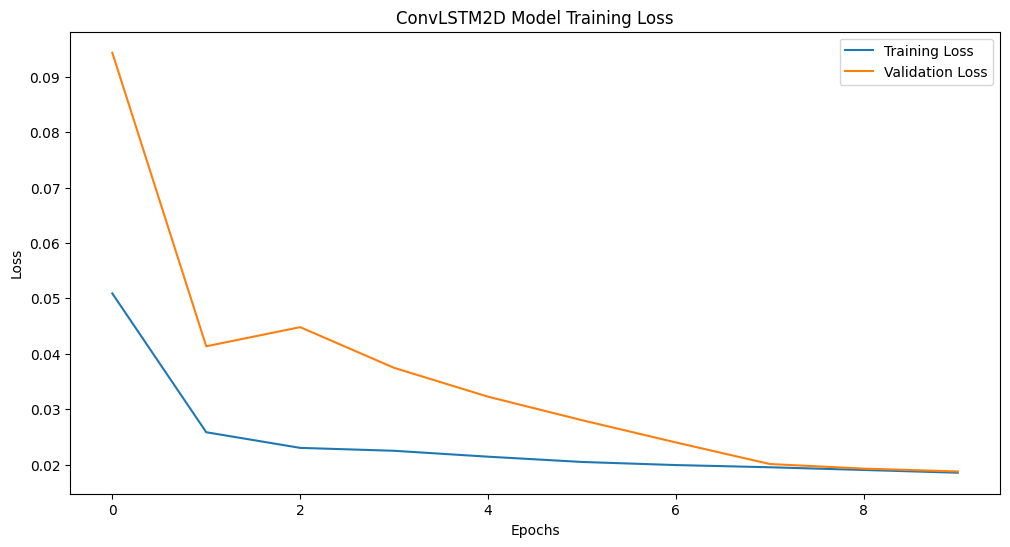

In [95]:
# 학습 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("ConvLSTM2D Model Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
def predict_and_visualize(model, X_data, y_data, index=0):
    """
    ConvLSTM2D 모델로 예측하고 결과를 시각화
    model: 학습된 ConvLSTM2D 모델
    X_data: 시계열 입력 데이터 (Time Step, H, W, C)
    y_data: 실제 정답 이미지
    index: 예측할 데이터의 인덱스
    """
    # 예측 대상 시퀀스 선택
    X_sample = X_data[index:index+1]  # (1, Time Step, H, W, C)
    y_true = y_data[index]  # 실제 정답 이미지

    # 예측 수행
    y_pred = model.predict(X_sample)[0]  # (H, W, C)

    # 시각화: 실제 이미지 vs 예측된 이미지
    plt.figure(figsize=(12, 5))

    # 입력 시퀀스 시각화
    for i in range(X_sample.shape[1]):
        plt.subplot(2, X_sample.shape[1] + 1, i + 1)
        plt.imshow(X_sample[0, i].squeeze(), cmap='gray')
        plt.title(f"Input {i+1}")
        plt.axis('off')

    # 실제 이미지 시각화
    plt.subplot(2, X_sample.shape[1] + 1, X_sample.shape[1] + 1)
    plt.imshow(y_true.squeeze(), cmap='gray')
    plt.title("True Image")
    plt.axis('off')

    # 예측된 이미지 시각화
    plt.subplot(2, X_sample.shape[1] + 1, X_sample.shape[1] + 2)
    plt.imshow(y_pred.squeeze(), cmap='gray')
    plt.title("Predicted Image")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


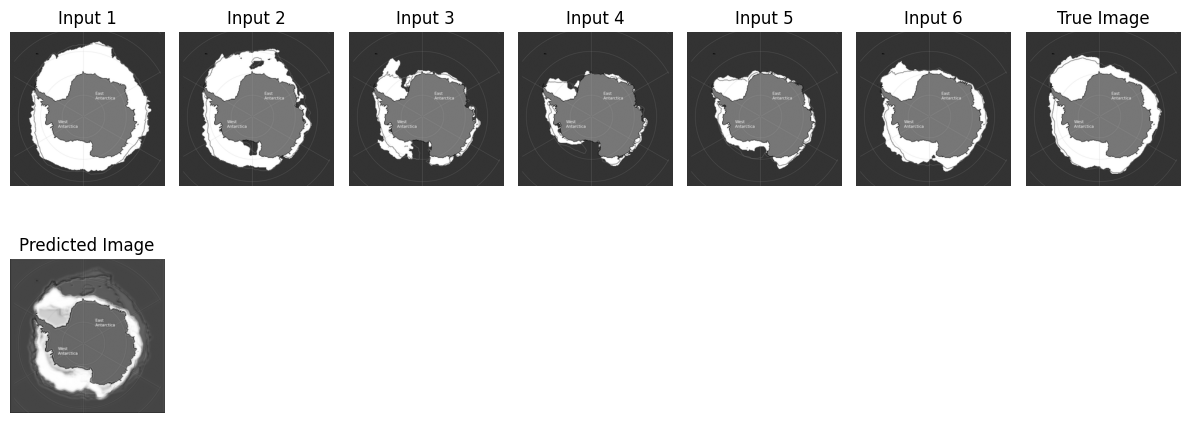

In [ ]:
# 예측 및 시각화 (첫 번째 시퀀스)
predict_and_visualize(model, X_data, y_data, index=0)

In [76]:
def create_projected_image(y_true, y_pred, save_path=None):
    """
    실제 이미지와 예측된 이미지를 투영하여 비교 이미지 생성
    y_true: 실제 이미지 (H, W) 또는 (H, W, 1)
    y_pred: 예측된 이미지 (H, W) 또는 (H, W, 1)
    save_path: 저장 경로 (기본값: None, 저장하지 않음)
    """
    # 이미지 형상 변환 (H, W, 1) -> (H, W)
    y_true = y_true.squeeze().astype(np.float32)
    y_pred = y_pred.squeeze().astype(np.float32)

    # 이미지 값 정규화 (0~1)로 맞추기
    if y_true.max() > 1.0:
        y_true = y_true / 255.0
    if y_pred.max() > 1.0:
        y_pred = y_pred / 255.0

    # 투영 이미지 생성 (Weighted Blending)
    blended = cv2.addWeighted(y_true, 0.5, y_pred, 0.5, 0)

    # 차이 이미지 (절대 차이)
    difference = np.abs(y_true - y_pred)
    difference_percentage = np.mean(difference) * 100  # 평균 차이 (0~1) -> %

    # 시각화: 투영 이미지 및 차이 이미지
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(y_true, cmap='gray')
    plt.title("True Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(y_pred, cmap='gray')
    plt.title("Predicted Image")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(blended, cmap='gray')
    plt.title(f"Projected Image\n(Difference: {difference_percentage:.2f}%)")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # 저장 옵션 (이미지 파일로 저장)
    if save_path:
        cv2.imwrite(save_path + "_true.png", (y_true * 255).astype(np.uint8))
        cv2.imwrite(save_path + "_pred.png", (y_pred * 255).astype(np.uint8))
        cv2.imwrite(save_path + "_projected.png", (blended * 255).astype(np.uint8))
        print(f"✅ 투영 이미지 저장 완료: {save_path}_projected.png")

    return blended, difference_percentage

In [77]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def create_projected_image_enhanced(y_true, y_pred, save_path=None, difference_threshold=0.1):
    """
    실제 이미지와 예측된 이미지를 투영하여 비교 이미지 생성 (차이 강조)
    y_true: 실제 이미지 (H, W) 또는 (H, W, 1)
    y_pred: 예측된 이미지 (H, W) 또는 (H, W, 1)
    save_path: 저장 경로 (기본값: None, 저장하지 않음)
    difference_threshold: 차이를 강조할 최소 임계값 (0~1)
    """
    # 이미지 형상 변환 (H, W, 1) -> (H, W)
    y_true = y_true.squeeze().astype(np.float32)
    y_pred = y_pred.squeeze().astype(np.float32)

    # 이미지 값 정규화 (0~1)로 맞추기
    if y_true.max() > 1.0:
        y_true = y_true / 255.0
    if y_pred.max() > 1.0:
        y_pred = y_pred / 255.0

    # 투영 이미지 생성 (Weighted Blending)
    blended = cv2.addWeighted(y_true, 0.5, y_pred, 0.5, 0)

    # 차이 이미지 (절대 차이)
    difference = np.abs(y_true - y_pred)
    difference_percentage = np.mean(difference) * 100  # 평균 차이 (0~1) -> %

    # 차이 강조 (Threshold 적용)
    difference_highlight = np.zeros_like(difference)
    difference_highlight[difference >= difference_threshold] = difference[difference >= difference_threshold]

    # 차이를 Heatmap으로 시각화 (컬러맵 적용)
    difference_colormap = cv2.applyColorMap((difference_highlight * 255).astype(np.uint8), cv2.COLORMAP_JET)

    # 시각화: 투영 이미지 및 차이 이미지 (강조)
    plt.figure(figsize=(16, 5))
    plt.subplot(1, 4, 1)
    plt.imshow(y_true, cmap='gray')
    plt.title("True Image")
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(y_pred, cmap='gray')
    plt.title("Predicted Image")
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(blended, cmap='gray')
    plt.title("Projected Image")
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(difference_colormap)
    plt.title(f"Difference (Threshold: {difference_threshold})")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # 저장 옵션 (이미지 파일로 저장)
    if save_path:
        cv2.imwrite(save_path + "_true.png", (y_true * 255).astype(np.uint8))
        cv2.imwrite(save_path + "_pred.png", (y_pred * 255).astype(np.uint8))
        cv2.imwrite(save_path + "_projected.png", (blended * 255).astype(np.uint8))
        cv2.imwrite(save_path + "_heatmap.png", difference_colormap)
        print(f"✅ 투영 이미지 저장 완료: {save_path}_projected.png")

    return blended, difference_percentage, difference_colormap

In [ ]:
best_model = tf.keras.models.load_model("/content/ConvLSTM2D_ice_time_step_3.h5")
best_model.compile(optimizer='adam', loss='mean_squared_error')

In [96]:
# 예측 대상 시퀀스 선택
index=0
X_sample = X_data[index:index+1]  # (1, Time Step, H, W, C)
y_true = y_data[index]  # 실제 정답 이미지

# 예측 수행
y_pred = model.predict(X_sample)[0]  # (H, W, C)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


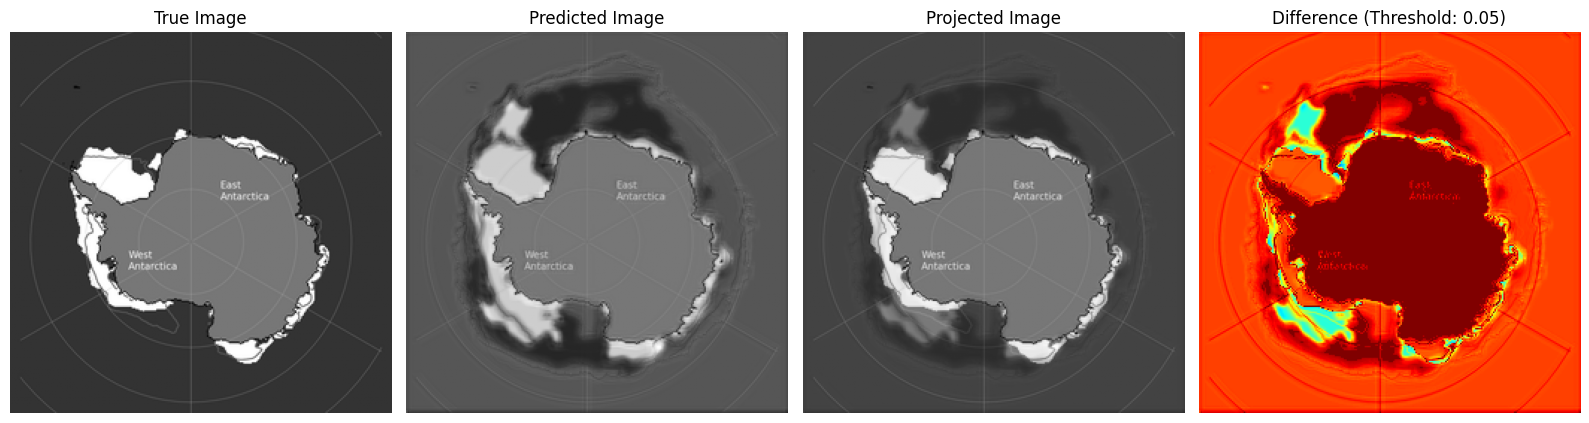

✅ 투영 이미지 저장 완료: projected_image_enhanced_threshold_projected.png
🔍 평균 차이 (Difference): 15.29%


In [ ]:
# 투영 이미지 생성 및 저장 (차이 임계값 10%)
blended_image, difference_percentage, heatmap = create_projected_image_enhanced(
    y_true, y_pred, save_path="projected_image_enhanced_threshold", difference_threshold=0.05
)

print(f"🔍 평균 차이 (Difference): {difference_percentage:.2f}%")

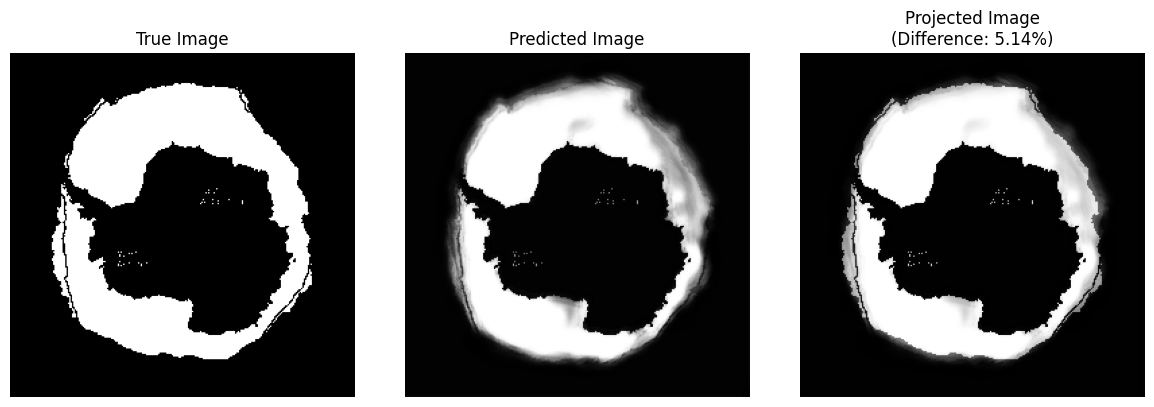

🔍 평균 차이 (Difference): 5.14%


In [97]:
# 투영 이미지 생성 및 저장
blended_image, difference_percentage = create_projected_image(
    y_true, y_pred)

print(f"🔍 평균 차이 (Difference): {difference_percentage:.2f}%")